# Lesson 4: Building a Multi-Document Agent

## Setup

In [1]:
from helper import get_openai_api_key
OPENAI_API_KEY = get_openai_api_key()

In [2]:
import nest_asyncio
nest_asyncio.apply()

## 1. Setup an agent over 3 papers

**Note**: The pdf files are included with this lesson. To access these papers, go to the `File` menu and select`Open...`.

In [3]:
urls = [
    "https://openreview.net/pdf?id=VtmBAGCN7o",
    "https://openreview.net/pdf?id=6PmJoRfdaK",
    "https://openreview.net/pdf?id=hSyW5go0v8",
]

papers = [
    "metagpt.pdf",
    "longlora.pdf",
    "selfrag.pdf",
]

In [4]:
from utils import get_doc_tools
from pathlib import Path

paper_to_tools_dict = {}
for paper in papers:
    print(f"Getting tools for paper: {paper}")
    vector_tool, summary_tool = get_doc_tools(paper, Path(paper).stem)
    paper_to_tools_dict[paper] = [vector_tool, summary_tool]

Getting tools for paper: metagpt.pdf
Getting tools for paper: longlora.pdf
Getting tools for paper: selfrag.pdf


In [5]:
initial_tools = [t for paper in papers for t in paper_to_tools_dict[paper]]

In [6]:
from llama_index.llms.openai import OpenAI

llm = OpenAI(model="gpt-3.5-turbo")

In [7]:
len(initial_tools)

6

In [8]:
from llama_index.core.agent import FunctionCallingAgentWorker
from llama_index.core.agent import AgentRunner

agent_worker = FunctionCallingAgentWorker.from_tools(
    initial_tools, 
    llm=llm, 
    verbose=True
)
agent = AgentRunner(agent_worker)

In [9]:
response = agent.query(
    "Tell me about the evaluation dataset used in LongLoRA, "
    "and then tell me about the evaluation results"
)

Added user message to memory: Tell me about the evaluation dataset used in LongLoRA, and then tell me about the evaluation results
=== Calling Function ===
Calling function: summary_tool_longlora with args: {"input": "evaluation dataset used in LongLoRA"}
=== Function Output ===
The evaluation dataset used in LongLoRA is the RedPajama dataset, the PG19 dataset, the PG19 validation set from the Redpajama dataset, the PG19 test split, LongAlpaca-12k, and SAFECONV.
=== Calling Function ===
Calling function: summary_tool_longlora with args: {"input": "evaluation results of LongLoRA"}
=== Function Output ===
The evaluation results of LongLoRA demonstrate its effectiveness in achieving comparable or even better performance than other Llama2-based long-context models, such as Vicuna and LongChat models. LongLoRA shows efficiency by requiring significantly lower computational overhead and fewer training hours compared to models like LoRA. It improves training speed and reduces GPU memory cost 

In [10]:
response = agent.query("Give me a summary of both Self-RAG and LongLoRA")
print(str(response))

Added user message to memory: Give me a summary of both Self-RAG and LongLoRA
=== Calling Function ===
Calling function: summary_tool_selfrag with args: {"input": "Self-RAG"}
=== Function Output ===
Self-RAG is a framework that enhances the quality and factuality of a large language model through retrieval and self-reflection. It trains a single arbitrary language model to adaptively retrieve passages on-demand, generate text informed by these passages, and reflect on its own generations using special tokens called reflection tokens. By incorporating retrieval and self-reflection, Self-RAG aims to improve the generation quality and factuality of the language model without compromising its original creativity and versatility.
=== Calling Function ===
Calling function: summary_tool_longlora with args: {"input": "LongLoRA"}
=== Function Output ===
LongLoRA is an efficient method for extending the context length of Large Language Models (LLMs) while minimizing computational costs. It combi

## 2. Setup an agent over 11 papers

### Download 11 ICLR papers

In [11]:
urls = [
    "https://openreview.net/pdf?id=VtmBAGCN7o",
    "https://openreview.net/pdf?id=6PmJoRfdaK",
    "https://openreview.net/pdf?id=LzPWWPAdY4",
    "https://openreview.net/pdf?id=VTF8yNQM66",
    "https://openreview.net/pdf?id=hSyW5go0v8",
    "https://openreview.net/pdf?id=9WD9KwssyT",
    "https://openreview.net/pdf?id=yV6fD7LYkF",
    "https://openreview.net/pdf?id=hnrB5YHoYu",
    "https://openreview.net/pdf?id=WbWtOYIzIK",
    "https://openreview.net/pdf?id=c5pwL0Soay",
    "https://openreview.net/pdf?id=TpD2aG1h0D"
]

papers = [
    "metagpt.pdf",
    "longlora.pdf",
    "loftq.pdf",
    "swebench.pdf",
    "selfrag.pdf",
    "zipformer.pdf",
    "values.pdf",
    "finetune_fair_diffusion.pdf",
    "knowledge_card.pdf",
    "metra.pdf",
    "vr_mcl.pdf"
]

To download these papers, below is the needed code:


    #for url, paper in zip(urls, papers):
         #!wget "{url}" -O "{paper}"
    
    
**Note**: The pdf files are included with this lesson. To access these papers, go to the `File` menu and select`Open...`.

In [12]:
from utils import get_doc_tools
from pathlib import Path

paper_to_tools_dict = {}
for paper in papers:
    print(f"Getting tools for paper: {paper}")
    vector_tool, summary_tool = get_doc_tools(paper, Path(paper).stem)
    paper_to_tools_dict[paper] = [vector_tool, summary_tool]

Getting tools for paper: metagpt.pdf
Getting tools for paper: longlora.pdf
Getting tools for paper: loftq.pdf
Getting tools for paper: swebench.pdf
Getting tools for paper: selfrag.pdf
Getting tools for paper: zipformer.pdf
Getting tools for paper: values.pdf
Getting tools for paper: finetune_fair_diffusion.pdf
Getting tools for paper: knowledge_card.pdf
Getting tools for paper: metra.pdf
Getting tools for paper: vr_mcl.pdf


### Extend the Agent with Tool Retrieval

In [13]:
all_tools = [t for paper in papers for t in paper_to_tools_dict[paper]]

The number of tools get limited by the context window of the LLMs leading to 
- High Cost
- LLMs confusing between the right tools
- All the tools do not fit in the context window

The fix is to retrieve the right subset of tools and then feed that for the next step. This retrieval can be thought of as a meta-retrieval where the original set of tools are documents over which we are performing information retrieval.

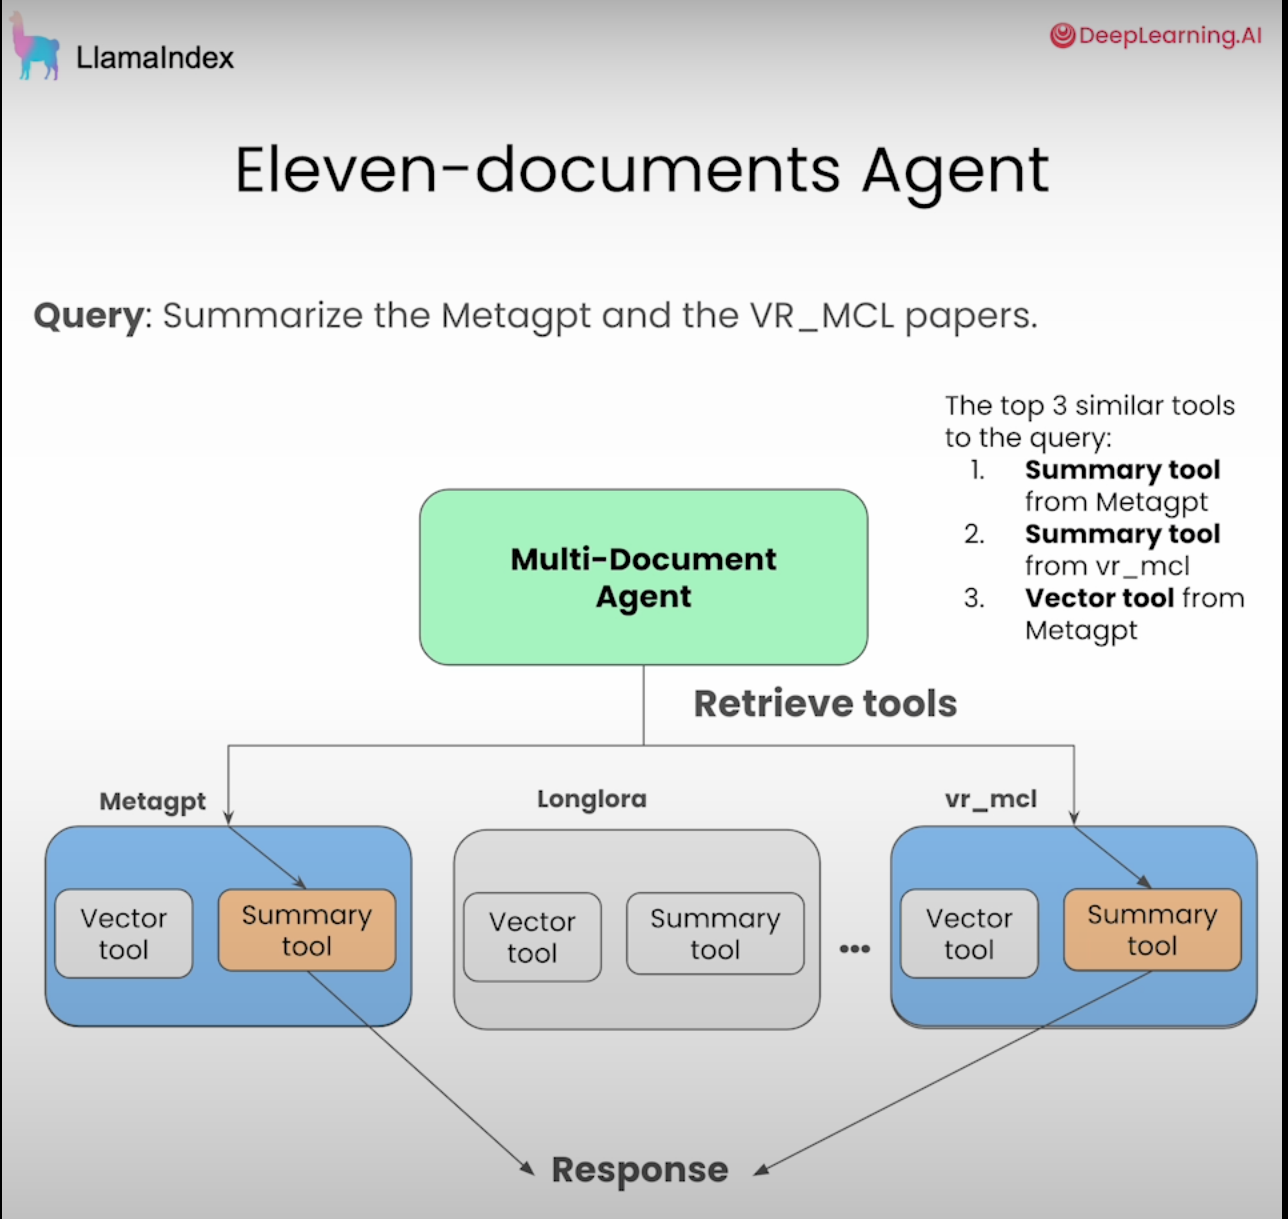

In [14]:
# define an "object" index and retriever over these tools
from llama_index.core import VectorStoreIndex
from llama_index.core.objects import ObjectIndex

obj_index = ObjectIndex.from_objects(
    all_tools,
    index_cls=VectorStoreIndex,
)

In [15]:
obj_retriever = obj_index.as_retriever(similarity_top_k=3)

In [16]:
tools = obj_retriever.retrieve(
    "Tell me about the eval dataset used in MetaGPT and SWE-Bench"
)

In [17]:
tools[2].metadata

ToolMetadata(description='Useful for summarization questions related to swebench', name='summary_tool_swebench', fn_schema=<class 'llama_index.core.tools.types.DefaultToolFnSchema'>, return_direct=False)

In [18]:
from llama_index.core.agent import FunctionCallingAgentWorker
from llama_index.core.agent import AgentRunner

agent_worker = FunctionCallingAgentWorker.from_tools(
    tool_retriever=obj_retriever,
    llm=llm, 
    system_prompt=""" \
You are an agent designed to answer queries over a set of given papers.
Please always use the tools provided to answer a question. Do not rely on prior knowledge.\

""",
    verbose=True
)
agent = AgentRunner(agent_worker)

In [19]:
response = agent.query(
    "Tell me about the evaluation dataset used "
    "in MetaGPT and compare it against SWE-Bench"
)
print(str(response))

Added user message to memory: Tell me about the evaluation dataset used in MetaGPT and compare it against SWE-Bench
=== Calling Function ===
Calling function: summary_tool_metagpt with args: {"input": "evaluation dataset used in MetaGPT"}
=== Function Output ===
The evaluation dataset used in MetaGPT includes HumanEval, MBPP, and SoftwareDev.
=== Calling Function ===
Calling function: summary_tool_swebench with args: {"input": "evaluation dataset used in SWE-Bench"}
=== Function Output ===
The evaluation dataset used in SWE-Bench consists of task instances drawn from real GitHub issues and corresponding pull requests across popular Python repositories. It includes task instructions, issue text, retrieved files and documentation, an example patch file, and a prompt for generating the patch file. The dataset aims to provide a challenging arena for evaluating and augmenting Language Models (LMs) with software engineering tools and practices. Task instances are validated through execution-

In [20]:
response = agent.query(
    "Compare and contrast the LoRA papers (LongLoRA, LoftQ). "
    "Analyze the approach in each paper first. "
)

Added user message to memory: Compare and contrast the LoRA papers (LongLoRA, LoftQ). Analyze the approach in each paper first. 
=== Calling Function ===
Calling function: summary_tool_longlora with args: {"input": "Compare and contrast the approach in the LongLoRA paper."}
=== Function Output ===
The approach in the LongLoRA paper focuses on efficiently extending the context length of large language models (LLMs) while minimizing computational costs. It introduces shifted sparse attention (S2-Attn) as a key component, which allows for efficient approximation of long context training while retaining the original attention architecture during inference. The paper emphasizes the importance of trainable embedding and normalization layers for effective long context LoRA fine-tuning. Additionally, LongLoRA introduces an improved version of LoRA called LoRA+ that opens up embedding and normalization layers for training, proving crucial for adapting LLMs to longer contexts. The paper bridges 